![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Calculate VPD from air temperature and relative humidity
</b>
</span>

---
**Notebook version**: `3` (24 Oct 2023)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Air temperature (TA) and relative humidity (RH) are two widely available measurements
- VPD can be calculated from TA and RH
- In this example, gap-filled TA is used in combination with RH (not gap-filled) to calculate VPD 
- `QuickFillRFTS` is used for quick gap-filling of the calculated VPD. It uses the input features in combination with timestamp info.

</br>

# **Imports**

In [1]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # Used for plotting
from diive.core.times.times import insert_timestamp  # Used to insert TIMESTAMP_END
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh  # Used to calculate VPD
from diive.pkgs.gapfilling.randomforest_ts import QuickFillRFTS  # Used for gap-filling

warnings.filterwarnings("ignore")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.82.1


</br>

# **Docstring**

In [2]:
help(calc_vpd_from_ta_rh)

Help on function calc_vpd_from_ta_rh in module diive.pkgs.createvar.vpd:

calc_vpd_from_ta_rh(df: pandas.core.frame.DataFrame, rh_col: str, ta_col: str) -> pandas.core.series.Series
    Calculate VPD from air temperature and relative humidity
    
    Args:
        df: Data
        rh_col: Name of column in *df* containing relative humidity data in %
        ta_col: Name of column in *df* containing air temperature data in °C
    
    Returns:
        VPD in kPa as Series
    
    Original code in ReddyProc:
        VPD.V.n <- 6.1078 * (1 - rH / 100) * exp(17.08085 * Tair / (234.175 + Tair))
        # See Kolle Logger Tools Software 2012 (Magnus coefficients for water between 0 and 100 degC)
        # Data vector of vapour pressure deficit (VPD, hPa (mbar))
    
    Reference:
        https://github.com/bgctw/REddyProc/blob/3c2b414c24900c17ab624c20b0e1726e6a813267/R/GeoFunctions.R#L96
    
    Checked against ReddyProc output, virtually the same, differences only 8 digits after comma.


</br>

# **Variables**
- Names of the required variables in the datafiles

In [3]:
ta_col = 'Tair_f'  # Air temperature (gap-filled) is used to calculate VPD
rh_col = 'RH'  # Relative humidity (not gap-filled) is used to calculate VPD

</br>

# **Newly created variables**

In [4]:
vpd_col = 'VPD_hPa'  # VPD will be newly calculated from gap-filled TA and non-gap-filled RH
vpd_gf_col = f'{vpd_col}_gfRF'  # Name of the gap-filled VPD in output

</br>

# **Load example data**

In [5]:
df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.039 seconds). Detected time resolution of <30 * Minutes> / 30min 


In [6]:
df

,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,NEE_CUT_84_orig,NEE_CUT_REF_f,NEE_CUT_REF_orig,PA,PPFD,PREC_TOT_T1_25+20_1,QCF_LE,QCF_NEE,Reco_CUT_16,Reco_CUT_84,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290,0.510,-0.082,0.705,0.0,0.0,0.0,13.093,NaN,194.913,1.376,NaN,1.537,NaN,1.595,NaN,832.520,0.017,0.0,NaN,1.0,1.886,1.455,2.300,1.252,1.908,1.613,0.510,0.0,0.0,31.933,34.977,-1.618,-1.618,0.288,1.339,1.339
2013-01-01 00:45:00,0.290,0.512,-0.084,0.708,0.0,0.0,0.0,13.093,NaN,193.568,1.376,NaN,1.537,NaN,1.595,NaN,832.430,0.031,0.0,NaN,NaN,1.888,1.454,2.303,1.241,1.914,1.616,0.512,0.0,0.0,32.600,34.977,-1.630,-1.630,0.288,1.337,1.337
2013-01-01 01:15:00,0.290,0.514,-0.086,0.710,0.0,0.0,0.0,13.066,NaN,193.135,1.376,NaN,1.537,NaN,1.595,NaN,832.207,-0.006,0.0,NaN,1.0,1.890,1.452,2.305,1.230,1.920,1.619,0.515,0.0,0.0,38.867,34.971,-1.644,-1.644,0.288,1.335,1.335
2013-01-01 01:45:00,0.290,1.354,-0.088,1.771,0.0,0.0,0.0,13.066,NaN,192.083,0.538,0.538,1.537,NaN,0.538,0.538,831.903,-0.018,0.0,NaN,0.0,1.892,1.450,2.308,1.219,1.926,1.622,0.518,0.0,0.0,37.767,34.975,-1.657,-1.657,0.288,1.332,1.332
2013-01-01 02:15:00,0.377,0.545,-0.080,0.797,0.0,0.0,0.0,16.995,NaN,192.677,1.544,NaN,1.709,NaN,1.765,NaN,831.680,0.007,0.0,NaN,1.0,2.090,1.630,2.562,1.347,2.105,1.790,0.578,0.0,0.0,39.533,34.967,-0.567,-0.567,0.288,3.545,3.545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016,0.373,0.203,0.600,0.0,0.0,0.0,-0.735,-0.735,230.499,0.629,NaN,1.253,NaN,1.224,NaN,842.985,0.000,0.0,1.0,1.0,1.001,1.456,1.824,2.568,1.221,1.032,0.759,0.0,0.0,71.790,19.572,3.463,3.463,0.288,2.210,2.210
2022-12-31 22:15:00,0.105,-2.379,0.894,-1.433,0.0,0.0,0.0,4.724,4.724,231.788,3.518,3.518,0.803,NaN,3.518,3.518,842.976,0.000,0.0,0.0,0.0,1.139,1.697,2.085,2.959,1.356,1.174,0.838,0.0,0.0,62.627,19.577,5.283,5.283,0.288,3.327,3.327
2022-12-31 22:45:00,0.220,-0.515,0.926,-0.305,0.0,0.0,0.0,9.840,NaN,237.303,1.673,NaN,0.803,NaN,2.424,NaN,842.965,0.000,0.0,2.0,1.0,1.158,1.729,2.119,3.038,1.367,1.199,0.857,0.0,0.0,61.747,19.589,5.537,5.537,0.288,3.467,3.467


</br>

# **Subset of required variables**

In [7]:
subsetcols = [ta_col, rh_col]
subset_df = df[subsetcols].copy()
subset_df

,Tair_f,RH
TIMESTAMP_MIDDLE,,
2013-01-01 00:15:00,-1.618,31.933
2013-01-01 00:45:00,-1.630,32.600
2013-01-01 01:15:00,-1.644,38.867
2013-01-01 01:45:00,-1.657,37.767
2013-01-01 02:15:00,-0.567,39.533
...,...,...
2022-12-31 21:45:00,3.463,71.790
2022-12-31 22:15:00,5.283,62.627
2022-12-31 22:45:00,5.537,61.747


</br>

# **Calculation of VPD**

In [8]:
subset_df[vpd_col] = calc_vpd_from_ta_rh(df=subset_df, ta_col=ta_col, rh_col=rh_col)

In [9]:
subset_df

,Tair_f,RH,VPD_hPa
TIMESTAMP_MIDDLE,,,
2013-01-01 00:15:00,-1.618,31.933,0.369156
2013-01-01 00:45:00,-1.630,32.600,0.365215
2013-01-01 01:15:00,-1.644,38.867,0.330913
2013-01-01 01:45:00,-1.657,37.767,0.336544
2013-01-01 02:15:00,-0.567,39.533,0.354322
...,...,...,...
2022-12-31 21:45:00,3.463,71.790,0.220998
2022-12-31 22:15:00,5.283,62.627,0.332739
2022-12-31 22:45:00,5.537,61.747,0.346656


</br>

# **Gap-filling VPD**
- Quick gap-filling, just using air temperature and timestamp info as predictors

In [10]:
gfcols = [vpd_col, ta_col]
gf_df = subset_df[gfcols].copy()
rfts = QuickFillRFTS(df=gf_df, target_col=vpd_col)
rfts.fill()
subset_df[vpd_gf_col] = rfts.get_gapfilled_target()


Adding new data columns ...
++ Added new columns with lagged variants for: ['Tair_f'] (lags between -1 and -1 with stepsize 1), no lagged variants for: ['VPD_hPa']. Shifting the time series created gaps which were then filled with the nearest value.
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...

Tra

In [11]:
subset_df

,Tair_f,RH,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,
2013-01-01 00:15:00,-1.618,31.933,0.369156,0.369156
2013-01-01 00:45:00,-1.630,32.600,0.365215,0.365215
2013-01-01 01:15:00,-1.644,38.867,0.330913,0.330913
2013-01-01 01:45:00,-1.657,37.767,0.336544,0.336544
2013-01-01 02:15:00,-0.567,39.533,0.354322,0.354322
...,...,...,...,...
2022-12-31 21:45:00,3.463,71.790,0.220998,0.220998
2022-12-31 22:15:00,5.283,62.627,0.332739,0.332739
2022-12-31 22:45:00,5.537,61.747,0.346656,0.346656


In [12]:
subset_df.describe()

,Tair_f,RH,VPD_hPa,VPD_hPa_gfRF
count,175296.000000,174589.000000,174589.000000,175296.000000
mean,4.712999,70.443842,0.322881,0.323193
std,7.548653,21.643410,0.371367,0.371200
min,-23.096000,4.200000,0.000000,0.000000
25%,-0.800000,53.600000,0.065685,0.066016
50%,4.600000,73.580000,0.197982,0.198723
75%,10.067000,89.767000,0.437258,0.437343
max,28.713000,100.000000,3.215735,3.215735


</br>

# **Plot some variables**

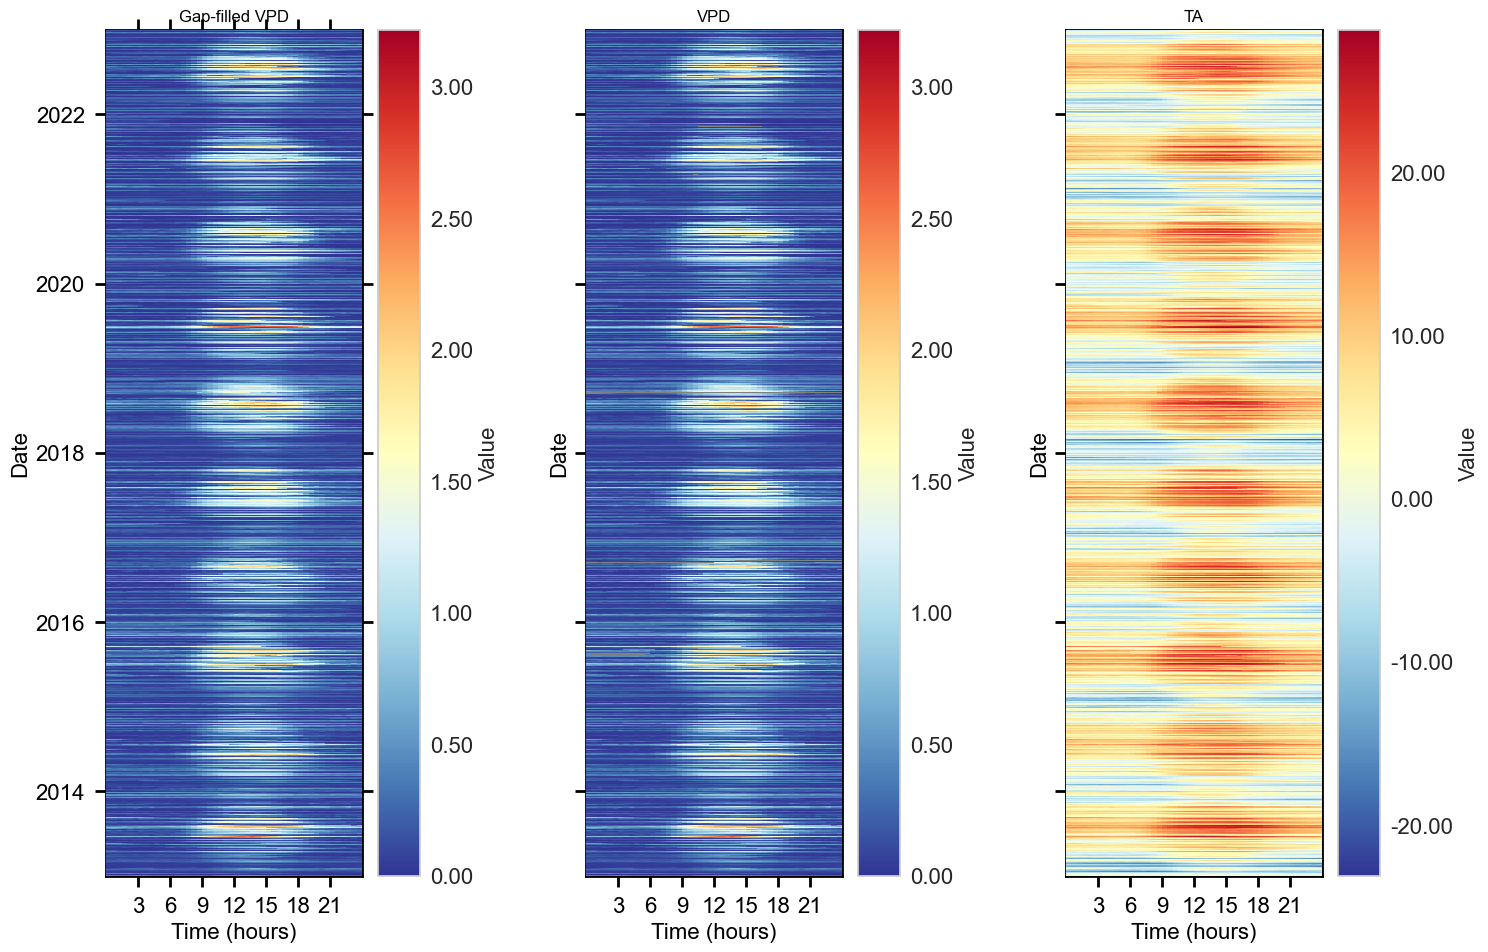

In [13]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
gs.update(wspace=0.5, hspace=0.1, left=0.1, right=0.9, top=0.97, bottom=0.03)
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=subset_df['VPD_hPa_gfRF']).plot()
HeatmapDateTime(ax=ax_le, series=subset_df['VPD_hPa']).plot()
HeatmapDateTime(ax=ax_ta, series=subset_df['Tair_f']).plot()
ax_fc.set_title("Gap-filled VPD", color='black')
ax_le.set_title("VPD", color='black')
ax_ta.set_title("TA", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                  labelleft=False, labelright=False, labeltop=False, labelbottom=True)

</br>

# **Insert TIMESTAMP_END**
- `diive` uses TIMESTAMP_MIDDLE for calculations, but sometimes TIMESTAMP_END is required for output files

In [14]:
subset_df = insert_timestamp(data=subset_df, convention='end')
subset_df

,TIMESTAMP_END,Tair_f,RH,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,,
2013-01-01 00:15:00,2013-01-01 00:30:00,-1.618,31.933,0.369156,0.369156
2013-01-01 00:45:00,2013-01-01 01:00:00,-1.630,32.600,0.365215,0.365215
2013-01-01 01:15:00,2013-01-01 01:30:00,-1.644,38.867,0.330913,0.330913
2013-01-01 01:45:00,2013-01-01 02:00:00,-1.657,37.767,0.336544,0.336544
2013-01-01 02:15:00,2013-01-01 02:30:00,-0.567,39.533,0.354322,0.354322
...,...,...,...,...,...
2022-12-31 21:45:00,2022-12-31 22:00:00,3.463,71.790,0.220998,0.220998
2022-12-31 22:15:00,2022-12-31 22:30:00,5.283,62.627,0.332739,0.332739
2022-12-31 22:45:00,2022-12-31 23:00:00,5.537,61.747,0.346656,0.346656


</br>

# **Save to CSV file**

In [15]:
# outfile = "vpd.csv"
# subset_df.to_csv(outfile, index=False)

</br>

# **End of notebook**

In [16]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-09-19 23:16:02
